In [95]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import mysql.connector as mysqlpy
import os
from pathlib import Path

## Chargement des datas

In [96]:
def get_db_connection():
    user = os.environ.get('DB_USER')
    password = os.environ.get('DB_PASSWORD')
    host = os.environ.get('DB_HOST')
    port = os.environ.get('DB_PORT')
    database = os.environ.get('DB_DATABASE')
    bdd = mysqlpy.connect(user=user, password=password, host=host, port=port, database=database)
    return bdd

bdd = get_db_connection()
cursor = bdd.cursor()
cursor.execute(f'''SELECT *, patients.name AS name_patient, anatomopathologists.name AS name_med FROM CRO 
               JOIN patients USING (nir) 
               JOIN diagnostics USING (id_diag) 
               JOIN anatomopathologists  USING (id_med);''')
CRO = cursor.fetchall()

columns=[i[0] for i in cursor.description]

CRO = pd.DataFrame(CRO, columns= columns)
CRO = CRO.drop(['name'], axis = 1)

cursor.execute(f'''SELECT * FROM diagnostics;''')
diag = cursor.fetchall()

columns=[i[0] for i in cursor.description]

diag = pd.DataFrame(diag, columns= columns)

cursor.close()

True

In [97]:
CRO.head(5)

,id_med,id_diag,nir,CRO,source,operation,address,birthday,organe,diagnostic,cancer,name_patient,name_med
0,59,2,1 1963 01 21813 466 38,Résumé opératoire d'Histopathologie :\nPatient...,mistralai/Mistral-7B-Instruct-v0.2,biopsie,"49, boulevard de Jacques, 21813 Legendre",15/01/1963,peau,mélanome,1,Gilbert Étienne,Dr Alice Brunet
1,56,20,1 1963 01 21813 466 38,Résumé anatomopathologique\nPatient : Gilbert ...,mistralai/Mistral-7B-Instruct-v0.2,colectomie,"49, boulevard de Jacques, 21813 Legendre",15/01/1963,côlon,polypose adénomateuse familiale,1,Gilbert Étienne,Dr Jeanne Boutin
2,7,2,1 1963 01 21813 466 38,Résumé anatomopathologique\nPatient : Gilbert ...,mistralai/Mistral-7B-Instruct-v0.2,biopsie,"49, boulevard de Jacques, 21813 Legendre",15/01/1963,peau,mélanome,1,Gilbert Étienne,Dr Olivier Grenier
3,3,16,1 1960 11 65552 524 96,Résumé anatomopathologique\nPatient : Joseph B...,mistralai/Mistral-7B-Instruct-v0.2,biopsie,"avenue Georges David, 65552 Saint Simone",04/11/1960,côlon,tumeur neuroendocrine,1,Joseph Berthelot,Dr Luc Hamel
4,58,19,1 1960 11 65552 524 96,Résumé anatomopathologique\nPatient : M. Josep...,mistralai/Mistral-7B-Instruct-v0.2,biopsie,"avenue Georges David, 65552 Saint Simone",04/11/1960,côlon,cancer colorectal héréditaire non polyposique,1,Joseph Berthelot,Dr Adrienne Delannoy


In [98]:
diag.head(5)

,organe,diagnostic,cancer,id_diag
0,peau,psoriasis,0,1
1,peau,mélanome,1,2
2,peau,rosacée,0,3
3,peau,lupus érythémateux,0,4
4,peau,lichen plan,0,5


In [99]:
CRO_train_valid = CRO.query('organe != "foie"').reset_index(drop=True)
CRO_test = CRO.query('organe == "foie"').reset_index(drop=True)

CRO_train, CRO_valid = train_test_split(CRO_train_valid, test_size=0.2, stratify=CRO_train_valid['id_diag'], random_state=42)
CRO_train= CRO_train.reset_index(drop=True)
CRO_valid = CRO_valid.reset_index(drop=True)

In [100]:
print(f'Dans le dataset primaire, il y a {len(CRO)} CRO.')
print(f'Dans le dataset train, il y a {len(CRO_train)} CRO.')
print(f'Dans le dataset valid, il y a {len(CRO_valid)} CRO.')
print(f'Dans le datasset test, il y a {len(CRO_test)} CRO.')

Dans le dataset primaire, il y a 1856 CRO.
Dans le dataset train, il y a 1346 CRO.
Dans le dataset valid, il y a 337 CRO.
Dans le datasset test, il y a 173 CRO.


# Data augmentation

In [101]:
def data_aug_CRO(CRO: pd.DataFrame, diag_inf_ref: dict, diag: pd.DataFrame, ref) -> list:
    '''
    Data augmentation en remplaçant le diagnostic dans un autre CRO, mais en conservant les autres données
    entrée:
        -CRO : df contenant tous les CRO
        -diag_inf_ref : dict des diagnostics à augmenter
        -diag : df de diagnostics pour récupérer l'id_diag
        -ref : nb de CRO qui doit être généré par class de diagnostic du CRO
    '''
    new_CRO_list = []
    for value, key in diag_inf_ref.items():
        nb_diag = len(CRO.query(f'diagnostic == "{value}"'))
        diag_value = diag.query(f'diagnostic == "{value}"')
        print(diag_value.id_diag)
        while nb_diag < ref:
            random_CRO = random.randint(0, len(CRO) - 1)
            old_CRO  = CRO.CRO[random_CRO].lower()
            new_CRO = old_CRO.replace(CRO.diagnostic[random_CRO].lower(), value.lower())
            new_CRO_list.append({'CRO': new_CRO,  'source': CRO.source[random_CRO], 'operation': CRO.operation[random_CRO],
                                 'nir': CRO.nir[random_CRO], 'name_patient': CRO.name_patient[random_CRO], 'address': CRO.address[random_CRO], 'birthday': CRO.birthday[random_CRO],
                                 'id_med': CRO.id_med[random_CRO], 'name_med': CRO.name_med[random_CRO],
                                 'id_diag': diag_value.id_diag.tolist()[0], 'diagnostic': diag_value.diagnostic.tolist()[0], 'organe': diag_value.organe.tolist()[0], 'cancer': diag_value.cancer.tolist()[0],   
                                })
            nb_diag += 1
            print('nb_diag', nb_diag, value)
    return new_CRO_list

In [148]:
nb_diag_train = 100
nb_diag_valid = nb_diag_train // 4 if nb_diag_train // 4 != 0 else 1
nb_diag_test = 20

print(nb_diag_train, nb_diag_valid, nb_diag_test)

100 25 20


## CRO Train

Text(0, 0.5, 'Occurence')

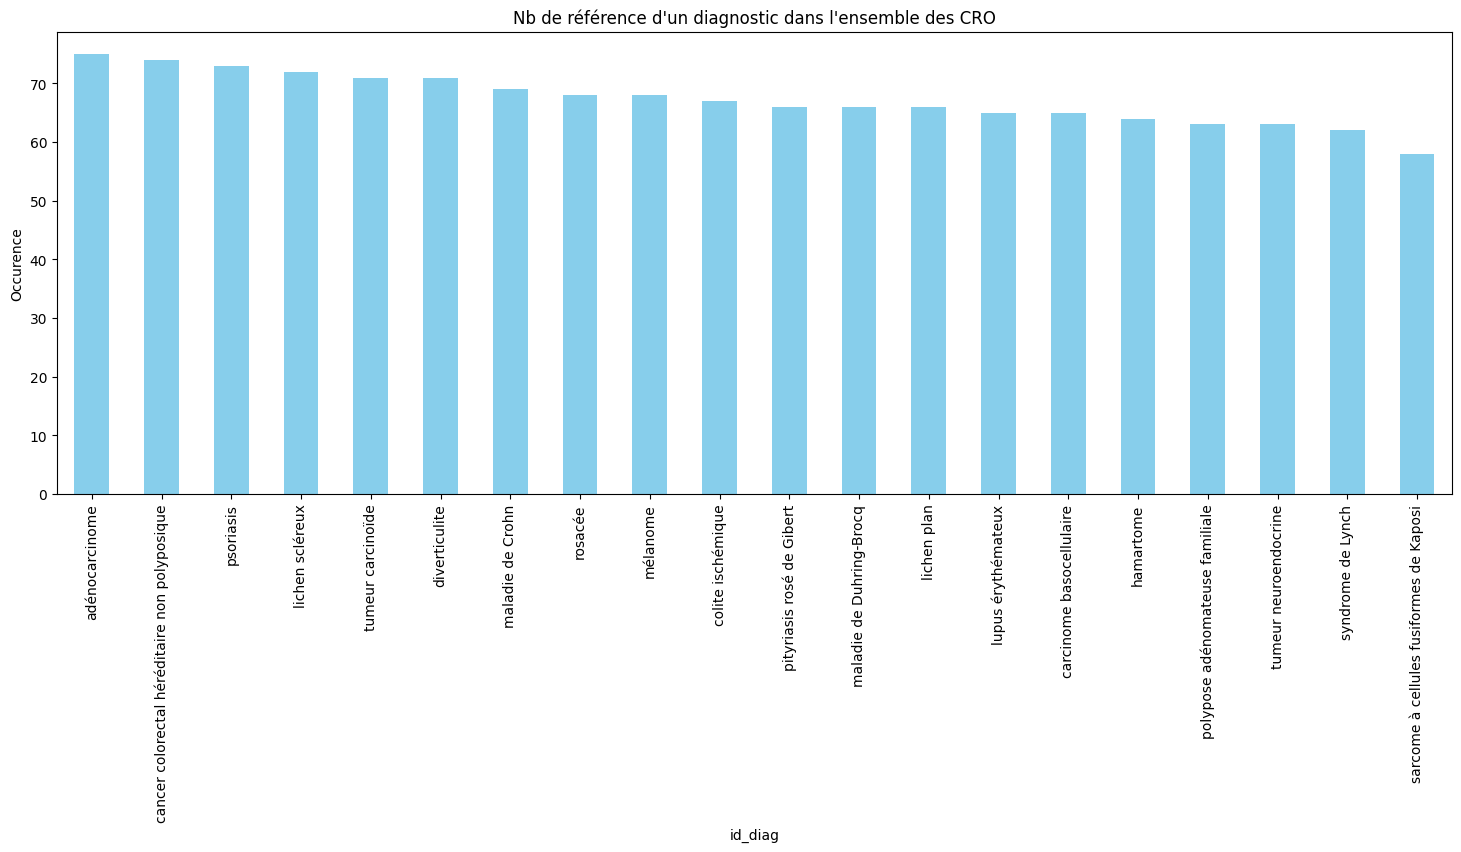

In [149]:
value_counts_train = CRO_train['diagnostic'].value_counts()

plt.figure(figsize=(18, 6))
value_counts_train.plot(kind='bar', color='skyblue')
plt.title("Nb de référence d'un diagnostic dans l'ensemble des CRO")
plt.xlabel('id_diag')
plt.ylabel('Occurence')

In [150]:
# diagnostics qui doivent être augmentés

diagnostics_nb = dict(value_counts_train)
ref = nb_diag_train
# Utilisation d'une compréhension de dictionnaire pour filtrer les clés
diag_inf_train_ref = {cle: valeur for cle, valeur in diagnostics_nb.items() if valeur < ref}
for key, value in diag_inf_train_ref.items():
    print(key, ':', value)

adénocarcinome : 75
cancer colorectal héréditaire non polyposique : 74
psoriasis : 73
lichen scléreux : 72
tumeur carcinoïde : 71
diverticulite : 71
maladie de Crohn : 69
rosacée : 68
mélanome : 68
colite ischémique : 67
pityriasis rosé de Gibert : 66
maladie de Duhring-Brocq : 66
lichen plan : 66
lupus érythémateux : 65
carcinome basocellulaire : 65
hamartome : 64
polypose adénomateuse familiale : 63
tumeur neuroendocrine : 63
syndrome de Lynch : 62
sarcome à cellules fusiformes de Kaposi : 58


In [151]:
print(f'nb de diag inf à {ref} :', len(diag_inf_train_ref.keys()))

nb de diag inf à 100 : 20


In [152]:
# data augmentation du train si nécessaire

new_CRO_train_list = data_aug_CRO(CRO_train, diag_inf_train_ref, diag, ref)

11    12
Name: id_diag, dtype: int64
nb_diag 76 adénocarcinome
nb_diag 77 adénocarcinome
nb_diag 78 adénocarcinome
nb_diag 79 adénocarcinome
nb_diag 80 adénocarcinome
nb_diag 81 adénocarcinome
nb_diag 82 adénocarcinome
nb_diag 83 adénocarcinome
nb_diag 84 adénocarcinome
nb_diag 85 adénocarcinome
nb_diag 86 adénocarcinome
nb_diag 87 adénocarcinome
nb_diag 88 adénocarcinome
nb_diag 89 adénocarcinome
nb_diag 90 adénocarcinome
nb_diag 91 adénocarcinome
nb_diag 92 adénocarcinome
nb_diag 93 adénocarcinome
nb_diag 94 adénocarcinome
nb_diag 95 adénocarcinome
nb_diag 96 adénocarcinome
nb_diag 97 adénocarcinome
nb_diag 98 adénocarcinome
nb_diag 99 adénocarcinome
nb_diag 100 adénocarcinome
18    19
Name: id_diag, dtype: int64
nb_diag 75 cancer colorectal héréditaire non polyposique
nb_diag 76 cancer colorectal héréditaire non polyposique
nb_diag 77 cancer colorectal héréditaire non polyposique
nb_diag 78 cancer colorectal héréditaire non polyposique
nb_diag 79 cancer colorectal héréditaire non po

In [153]:
new_CRO_train = pd.DataFrame(new_CRO_train_list)
new_CRO_train.head()

,CRO,source,operation,nir,name_patient,address,birthday,id_med,name_med,id_diag,diagnostic,organe,cancer
0,résumé opératoire d'histopathologie\npatient :...,mistralai/Mistral-7B-Instruct-v0.2,exérèse,1 1980 01 38964 514 29,Bertrand Lemoine,"96, rue Honoré Hoareau, 38964 Delmas",10/01/1980,5,Dr Daniel Maillot,12,adénocarcinome,côlon,1
1,résumé anatomopathologique\npatient : m. benja...,mistralai/Mistral-7B-Instruct-v0.2,biopsie,1 1948 12 72655 239 21,Benjamin Vaillant,"65, avenue de Barre, 72655 Sainte Dominique",01/12/1948,51,Dr Inès Cohen,12,adénocarcinome,côlon,1
2,résumé anatomopathologique\npatient : amélie d...,mistralai/Mistral-7B-Instruct-v0.2,colectomie,2 2001 07 87283 983 57,Amélie Dubois,"8, chemin de Bernard, 87283 Sainte Valentineboeuf",14/07/2001,6,Dr Auguste Bouvier,12,adénocarcinome,côlon,1
3,résumé opératoire d'histopathologie\npatient :...,mistralai/Mistral-7B-Instruct-v0.2,biopsie,1 1960 11 65552 524 96,Joseph Berthelot,"avenue Georges David, 65552 Saint Simone",04/11/1960,2,Dr Antoine Brunet,12,adénocarcinome,côlon,1
4,résumé anatomo-pathologique\npatient : m. bern...,mistralai/Mistral-7B-Instruct-v0.2,biopsie,1 2007 06 35158 126 25,Bernard Schmitt,"92, avenue Nathalie Le Goff, 35158 Sainte Thib...",11/06/2007,50,Dr Marine Barbier,12,adénocarcinome,côlon,1


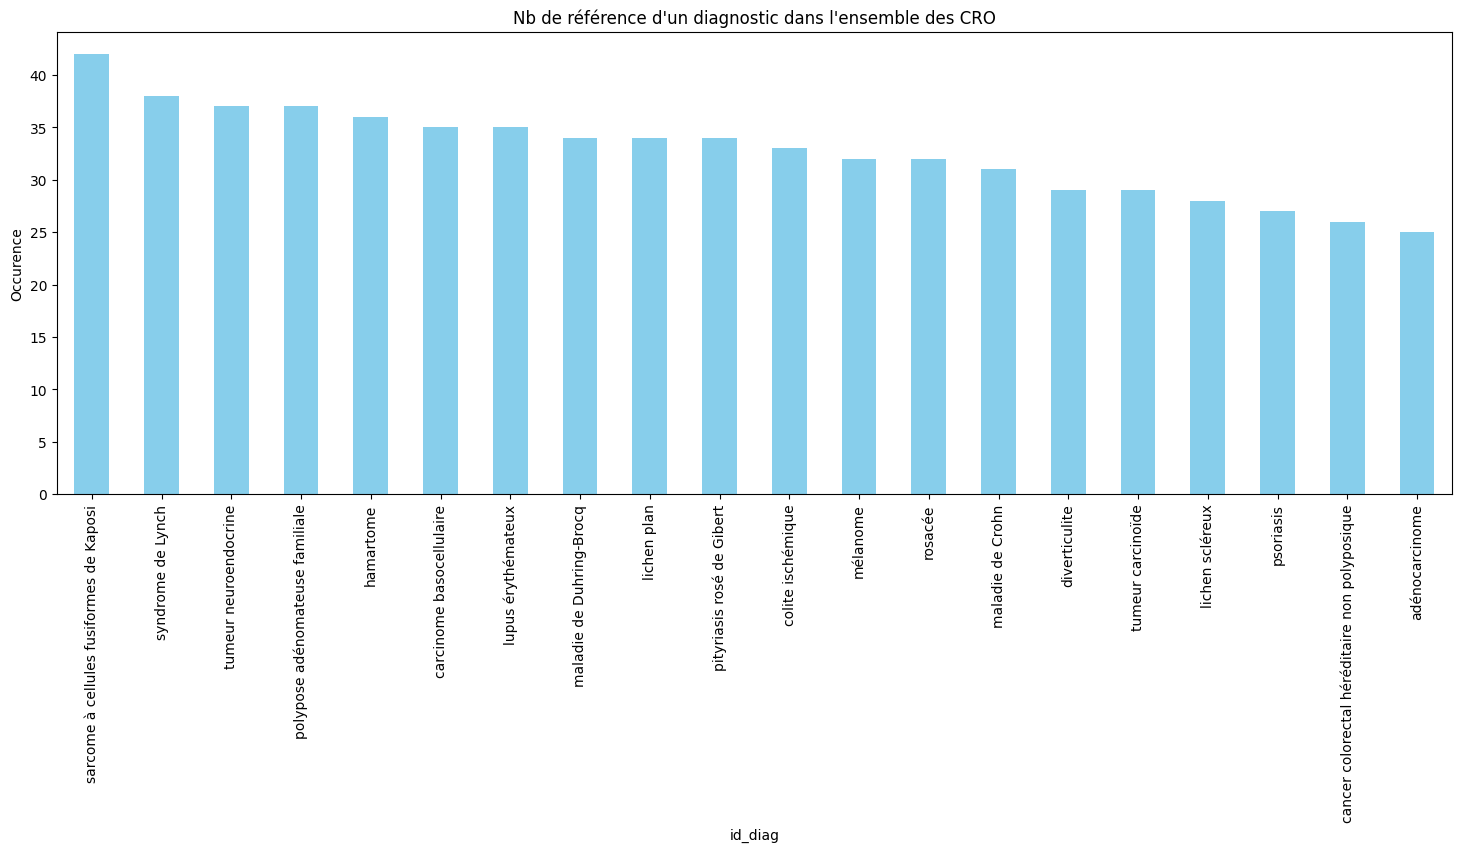

In [154]:
# affichage des diag augmentés

try: 
    value_counts_bis = new_CRO_train['diagnostic'].value_counts()

    plt.figure(figsize=(18, 6))
    value_counts_bis.plot(kind='bar', color='skyblue')
    plt.title("Nb de référence d'un diagnostic dans l'ensemble des CRO")
    plt.xlabel('id_diag')
    plt.ylabel('Occurence')
except:
    new_CRO_train = new_CRO_train

In [155]:
#  ajout des nouveaux CRO aux anciens

CRO_train_fusion = pd.concat([CRO_train, new_CRO_train], ignore_index=True)
CRO_train_fusion.head()

,id_med,id_diag,nir,CRO,source,operation,address,birthday,organe,diagnostic,cancer,name_patient,name_med
0,53,1,2 1935 08 30194 424 27,Résumé anatomopathologique\nPatient : Mme Virg...,mistralai/Mistral-7B-Instruct-v0.2,exérèse,"boulevard Nicole Marty, 30194 Saint Élisabethdan",27/08/1935,peau,psoriasis,0,Virginie Gonzalez,Dr Émilie Baron
1,8,13,1 1998 03 74510 756 57,Résumé anatomopathologique\nPatient : Alexandr...,mistralai/Mistral-7B-Instruct-v0.2,biopsie,"3, boulevard Simon, 74510 Devaux",17/03/1998,côlon,diverticulite,1,Alexandre Clément,Dr Antoine Jacquet
2,50,2,1 1993 07 46329 513 71,Résumé anatomopathologique\nPatient : Etienne ...,mistralai/Mistral-7B-Instruct-v0.2,biopsie,"avenue de Munoz, 46329 Giraud",26/07/1993,peau,mélanome,1,Étienne Techer,Dr Marine Barbier
3,2,9,2 1960 04 56399 501 68,Rapport d'anatomopathologie :\nPatient : Mme C...,mistralai/Mistral-7B-Instruct-v0.2,biopsie,"76, chemin de Louis, 56399 Laurent",19/04/1960,peau,maladie de Duhring-Brocq,0,Chantal Mercier,Dr Antoine Brunet
4,50,7,2 1951 09 24163 333 42,Résumé anatomo-pathologique\nPatient : Mme Océ...,mistralai/Mistral-7B-Instruct-v0.2,biopsie,"23, rue de Pineau, 24163 Sainte Adélaïdeboeuf",25/09/1951,peau,lichen scléreux,0,Océane Vaillant,Dr Marine Barbier


In [156]:
print(len(new_CRO_train))
print(len(CRO_train))
print(len(new_CRO_train) + len(CRO_train))
print(len(CRO_train_fusion))

654
1346
2000
2000


Text(0, 0.5, 'Occurence')

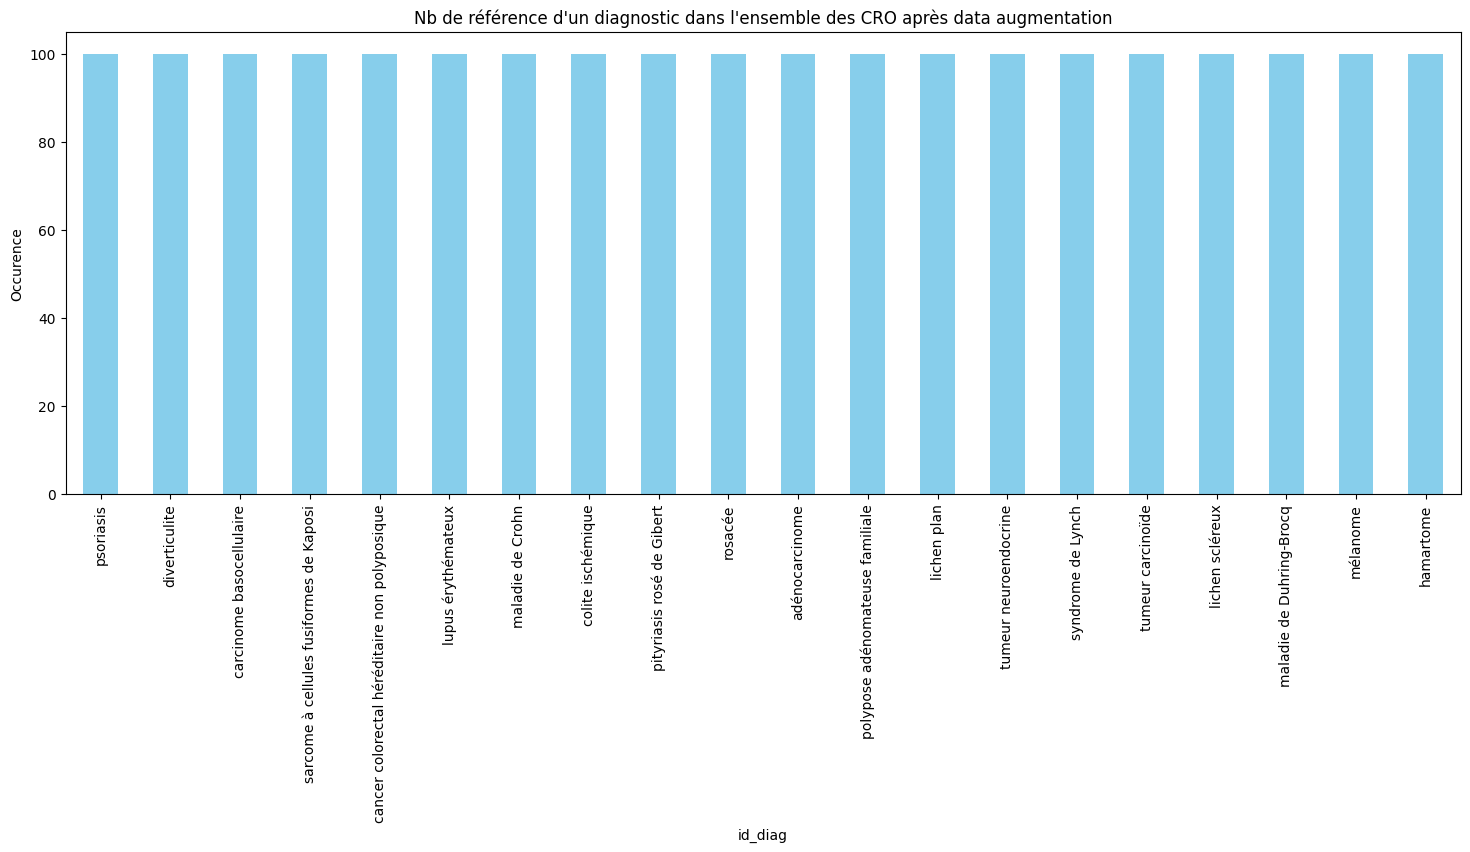

In [157]:
value_counts_bis_bis = CRO_train_fusion['diagnostic'].value_counts()

plt.figure(figsize=(18, 6))
value_counts_bis_bis.plot(kind='bar', color='skyblue')
plt.title("Nb de référence d'un diagnostic dans l'ensemble des CRO après data augmentation")
plt.xlabel('id_diag')
plt.ylabel('Occurence')

In [158]:
# Mise à niveau du dataframe pour correspondre à la limite sélectionnée par diag

nb_lignes_par_classe = ref
grouped_CRO_train = CRO_train_fusion.groupby('diagnostic', group_keys=False)
CRO_train_eq = grouped_CRO_train.apply(lambda x: x.sample(nb_lignes_par_classe, random_state=42))
CRO_train_eq = CRO_train_eq.reset_index(drop=True)

print('avant mise à niveau:',len(CRO_train_fusion))
print('après mise à niveau:',len(CRO_train_eq))

avant mise à niveau: 2000
après mise à niveau: 2000


In [159]:
print(CRO_train_eq['diagnostic'].value_counts())

diagnostic
adénocarcinome                                   100
cancer colorectal héréditaire non polyposique    100
tumeur carcinoïde                                100
syndrome de Lynch                                100
sarcome à cellules fusiformes de Kaposi          100
rosacée                                          100
psoriasis                                        100
polypose adénomateuse familiale                  100
pityriasis rosé de Gibert                        100
mélanome                                         100
maladie de Duhring-Brocq                         100
maladie de Crohn                                 100
lupus érythémateux                               100
lichen scléreux                                  100
lichen plan                                      100
hamartome                                        100
diverticulite                                    100
colite ischémique                                100
carcinome basocellulaire           

## CRO Valid

Text(0, 0.5, 'Occurence')

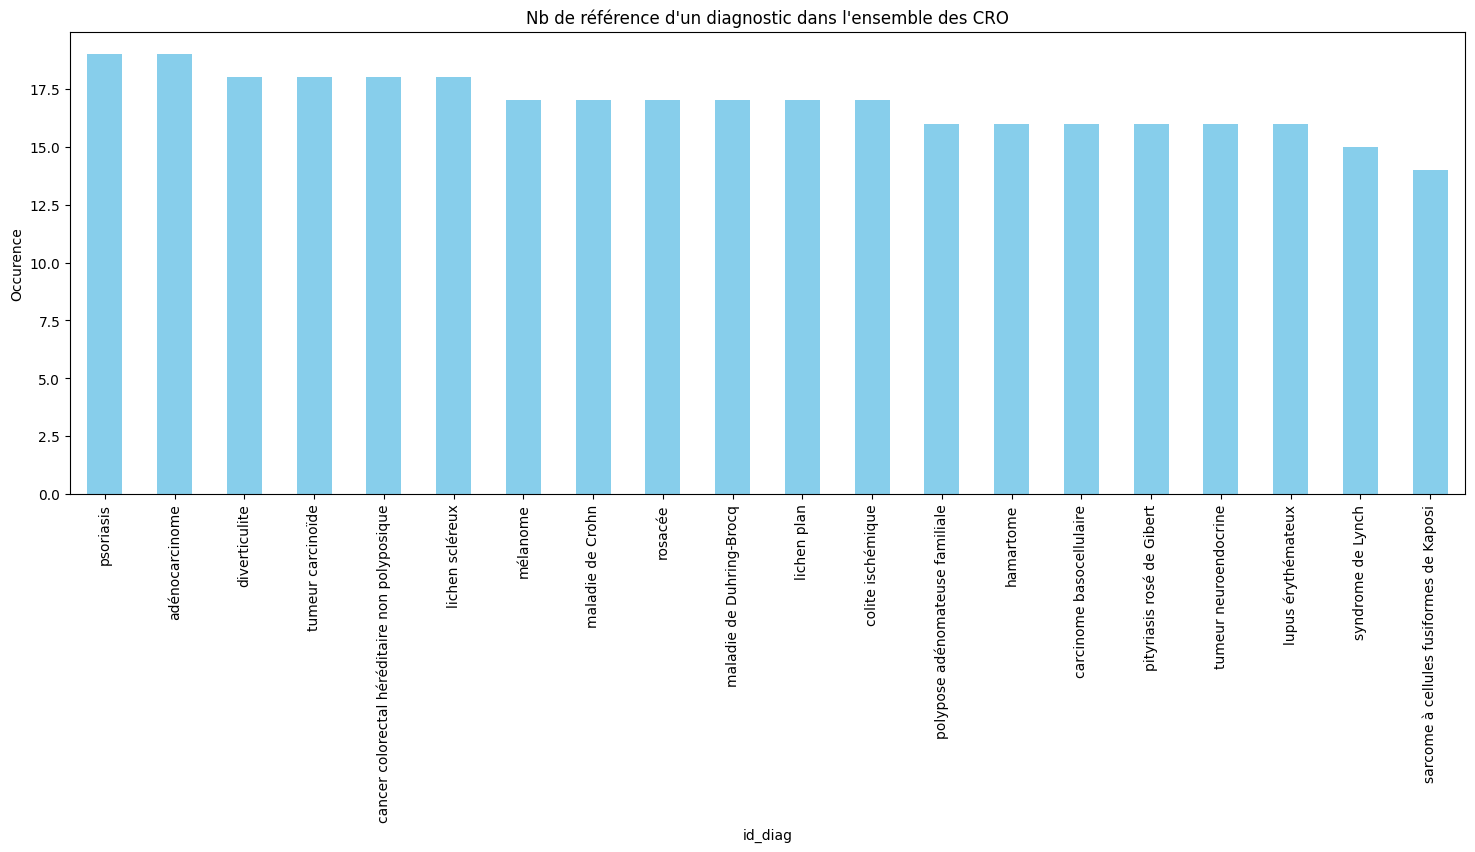

In [160]:
value_counts_valid = CRO_valid['diagnostic'].value_counts()

plt.figure(figsize=(18, 6))
value_counts_valid.plot(kind='bar', color='skyblue')
plt.title("Nb de référence d'un diagnostic dans l'ensemble des CRO")
plt.xlabel('id_diag')
plt.ylabel('Occurence')

In [161]:
# diagnostics qui doivent être augmentés

diagnostics_nb = dict(value_counts_valid)
ref = nb_diag_valid
# Utilisation d'une compréhension de dictionnaire pour filtrer les clés
diag_inf_valid_ref = {cle: valeur for cle, valeur in diagnostics_nb.items() if valeur < ref}
for key, value in diag_inf_valid_ref.items():
    print(key, ':', value)

psoriasis : 19
adénocarcinome : 19
diverticulite : 18
tumeur carcinoïde : 18
cancer colorectal héréditaire non polyposique : 18
lichen scléreux : 18
mélanome : 17
maladie de Crohn : 17
rosacée : 17
maladie de Duhring-Brocq : 17
lichen plan : 17
colite ischémique : 17
polypose adénomateuse familiale : 16
hamartome : 16
carcinome basocellulaire : 16
pityriasis rosé de Gibert : 16
tumeur neuroendocrine : 16
lupus érythémateux : 16
syndrome de Lynch : 15
sarcome à cellules fusiformes de Kaposi : 14


In [162]:
print(f'nb de diag inf à {ref} :', len(diag_inf_valid_ref.keys()))

nb de diag inf à 25 : 20


In [163]:
# data augmentation du train si nécessaire

new_CRO_valid_list = data_aug_CRO(CRO_valid, diag_inf_valid_ref, diag, ref)

0    1
Name: id_diag, dtype: int64
nb_diag 20 psoriasis
nb_diag 21 psoriasis
nb_diag 22 psoriasis
nb_diag 23 psoriasis
nb_diag 24 psoriasis
nb_diag 25 psoriasis
11    12
Name: id_diag, dtype: int64
nb_diag 20 adénocarcinome
nb_diag 21 adénocarcinome
nb_diag 22 adénocarcinome
nb_diag 23 adénocarcinome
nb_diag 24 adénocarcinome
nb_diag 25 adénocarcinome
12    13
Name: id_diag, dtype: int64
nb_diag 19 diverticulite
nb_diag 20 diverticulite
nb_diag 21 diverticulite
nb_diag 22 diverticulite
nb_diag 23 diverticulite
nb_diag 24 diverticulite
nb_diag 25 diverticulite
14    15
Name: id_diag, dtype: int64
nb_diag 19 tumeur carcinoïde
nb_diag 20 tumeur carcinoïde
nb_diag 21 tumeur carcinoïde
nb_diag 22 tumeur carcinoïde
nb_diag 23 tumeur carcinoïde
nb_diag 24 tumeur carcinoïde
nb_diag 25 tumeur carcinoïde
18    19
Name: id_diag, dtype: int64
nb_diag 19 cancer colorectal héréditaire non polyposique
nb_diag 20 cancer colorectal héréditaire non polyposique
nb_diag 21 cancer colorectal héréditaire no

In [164]:
new_CRO_valid = pd.DataFrame(new_CRO_valid_list)
new_CRO_valid.head()

,CRO,source,operation,nir,name_patient,address,birthday,id_med,name_med,id_diag,diagnostic,organe,cancer
0,résumé anatomopathologique\npatient : mme susa...,mistralai/Mistral-7B-Instruct-v0.2,colectomie,2 1980 10 97375 990 10,Susan Rémy,"rue Louis Colin, 97375 Texier-sur-Delmas",23/10/1980,0,Dr Zacharie Mercier,1,psoriasis,peau,0
1,résumé anatomopathologique\npatient : alexandr...,mistralai/Mistral-7B-Instruct-v0.2,biopsie,1 1998 03 74510 756 57,Alexandre Clément,"3, boulevard Simon, 74510 Devaux",17/03/1998,7,Dr Olivier Grenier,1,psoriasis,peau,0
2,résumé opératoire d'histopathologie\npatient :...,mistralai/Mistral-7B-Instruct-v0.2,exérèse,1 1948 12 72655 239 21,Benjamin Vaillant,"65, avenue de Barre, 72655 Sainte Dominique",01/12/1948,0,Dr Zacharie Mercier,1,psoriasis,peau,0
3,résumé anatomo-pathologique\npatient : mme océ...,mistralai/Mistral-7B-Instruct-v0.2,colectomie,2 1951 09 24163 333 42,Océane Vaillant,"23, rue de Pineau, 24163 Sainte Adélaïdeboeuf",25/09/1951,1,Dr Olivier Bernier,1,psoriasis,peau,0
4,résumé anatomopathologique\npatient : gilbert ...,mistralai/Mistral-7B-Instruct-v0.2,exérèse,1 1963 01 21813 466 38,Gilbert Étienne,"49, boulevard de Jacques, 21813 Legendre",15/01/1963,6,Dr Auguste Bouvier,1,psoriasis,peau,0


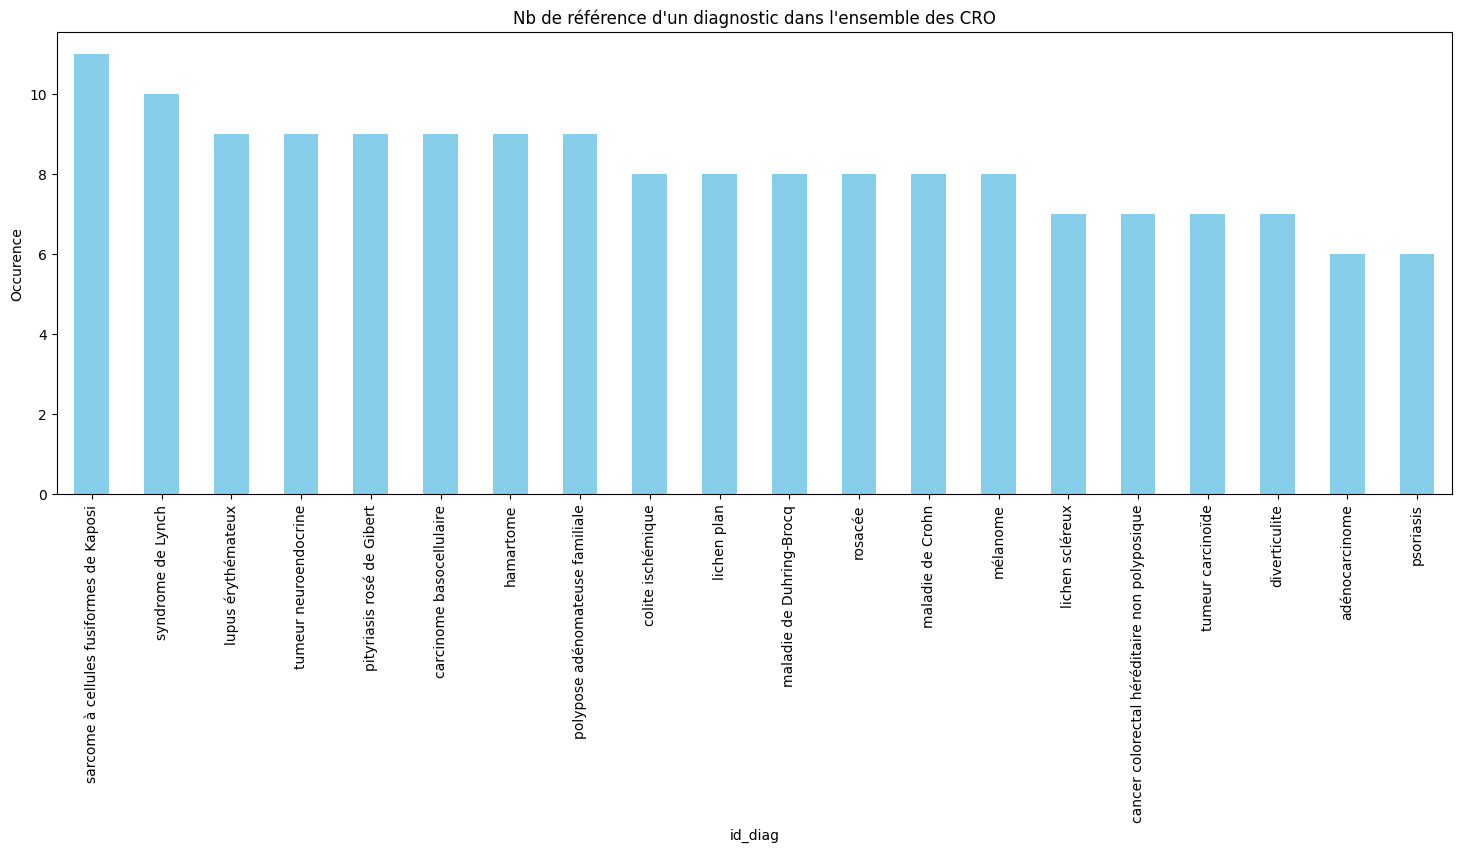

In [165]:
# affichage des diag augmentés

try:
    value_counts_bis = new_CRO_valid['diagnostic'].value_counts()

    plt.figure(figsize=(18, 6))
    value_counts_bis.plot(kind='bar', color='skyblue')
    plt.title("Nb de référence d'un diagnostic dans l'ensemble des CRO")
    plt.xlabel('id_diag')
    plt.ylabel('Occurence')
except:
    new_CRO_valid = new_CRO_valid

In [166]:
#  ajout des nouveaux CRO aux anciens

CRO_valid_fusion = pd.concat((CRO_valid, new_CRO_valid), ignore_index=True)
CRO_valid_fusion.head(5)

,id_med,id_diag,nir,CRO,source,operation,address,birthday,organe,diagnostic,cancer,name_patient,name_med
0,53,10,1 1993 07 46329 513 71,Résumé anatomopathologique\nPatient : Etienne ...,mistralai/Mistral-7B-Instruct-v0.2,biopsie,"avenue de Munoz, 46329 Giraud",26/07/1993,peau,sarcome à cellules fusiformes de Kaposi,0,Étienne Techer,Dr Émilie Baron
1,54,19,1 2007 06 35158 126 25,Résumé anatomopathologique\nPatient : M. Berna...,mistralai/Mistral-7B-Instruct-v0.2,colectomie,"92, avenue Nathalie Le Goff, 35158 Sainte Thib...",11/06/2007,côlon,cancer colorectal héréditaire non polyposique,1,Bernard Schmitt,Dr Aimée Poirier
2,55,1,1 1960 11 65552 524 96,Rapport d'anatomico-pathologique (RAPID : Repo...,mistralai/Mistral-7B-Instruct-v0.2,biopsie,"avenue Georges David, 65552 Saint Simone",04/11/1960,peau,psoriasis,0,Joseph Berthelot,Dr Chantal Laurent
3,53,4,2 1981 08 17268 040 85,Résumé anatomopathologique\nPatient : Mme Océa...,mistralai/Mistral-7B-Instruct-v0.2,exérèse,"chemin de Hamon, 17268 LecomteVille",21/08/1981,peau,lupus érythémateux,0,Océane Perrot,Dr Émilie Baron
4,57,16,1 1963 01 21813 466 38,Résumé anatomopathologique\nPatient : Gilbert ...,mistralai/Mistral-7B-Instruct-v0.2,biopsie,"49, boulevard de Jacques, 21813 Legendre",15/01/1963,côlon,tumeur neuroendocrine,1,Gilbert Étienne,Dr Inès Toussaint


In [167]:
print(len(new_CRO_valid))
print(len(CRO_valid))
print(len(new_CRO_valid) + len(CRO_valid))
print(len(CRO_valid_fusion))

163
337
500
500


Text(0, 0.5, 'Occurence')

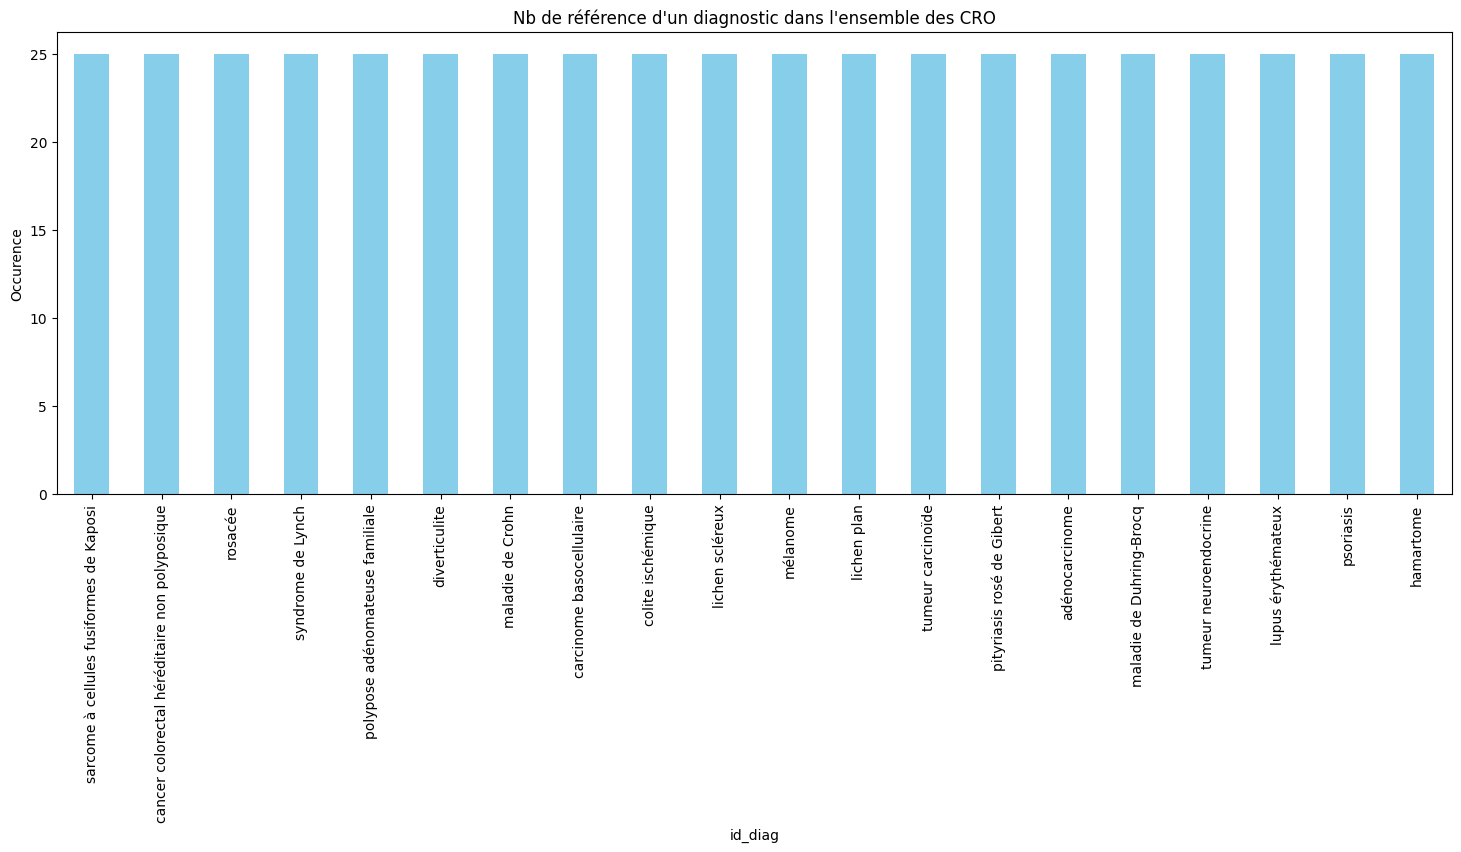

In [168]:
value_counts_bis_bis = CRO_valid_fusion['diagnostic'].value_counts()

plt.figure(figsize=(18, 6))
value_counts_bis_bis.plot(kind='bar', color='skyblue')
plt.title("Nb de référence d'un diagnostic dans l'ensemble des CRO")
plt.xlabel('id_diag')
plt.ylabel('Occurence')

In [169]:
# Mise à niveau du dataframe pour correspondre à la limite sélectionnée par diag

nb_lignes_par_classe = ref

grouped_CRO_valid = CRO_valid_fusion.groupby('diagnostic', group_keys=False)
CRO_valid_eq = grouped_CRO_valid.apply(lambda x: x.sample(nb_lignes_par_classe, random_state=42))
CRO_valid_eq = CRO_valid_eq.reset_index(drop=True)

print('avant réduction:',len(CRO_valid_fusion))
print('après réduction:',len(CRO_valid_eq))

avant réduction: 500
après réduction: 500


In [170]:
print(CRO_valid_eq['diagnostic'].value_counts())

diagnostic
adénocarcinome                                   25
cancer colorectal héréditaire non polyposique    25
tumeur carcinoïde                                25
syndrome de Lynch                                25
sarcome à cellules fusiformes de Kaposi          25
rosacée                                          25
psoriasis                                        25
polypose adénomateuse familiale                  25
pityriasis rosé de Gibert                        25
mélanome                                         25
maladie de Duhring-Brocq                         25
maladie de Crohn                                 25
lupus érythémateux                               25
lichen scléreux                                  25
lichen plan                                      25
hamartome                                        25
diverticulite                                    25
colite ischémique                                25
carcinome basocellulaire                         25
t

## CRO Test

Text(0, 0.5, 'Occurence')

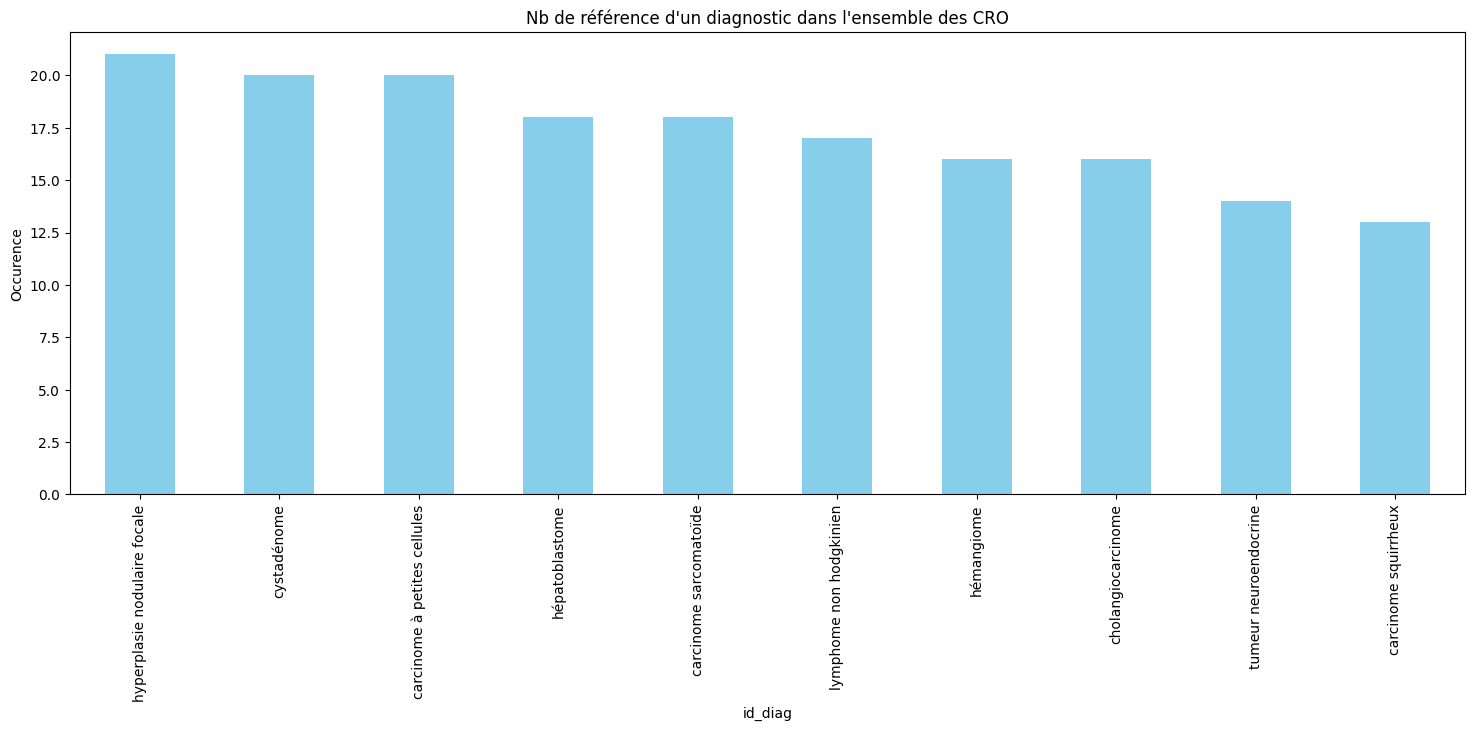

In [171]:
value_counts_test = CRO_test['diagnostic'].value_counts()

plt.figure(figsize=(18, 6))
value_counts_test.plot(kind='bar', color='skyblue')
plt.title("Nb de référence d'un diagnostic dans l'ensemble des CRO")
plt.xlabel('id_diag')
plt.ylabel('Occurence')

In [172]:
# diagnostics qui doivent être augmentés

diagnostics_nb = dict(value_counts_test)
ref = nb_diag_test
# Utilisation d'une compréhension de dictionnaire pour filtrer les clés
diag_inf_test_ref = {cle: valeur for cle, valeur in diagnostics_nb.items() if valeur < ref}
for key, value in diag_inf_test_ref.items():
    print(key, ':', value)

hépatoblastome : 18
carcinome sarcomatoïde : 18
lymphome non hodgkinien : 17
hémangiome : 16
cholangiocarcinome : 16
tumeur neuroendocrine : 14
carcinome squirrheux : 13


In [173]:
print(f'nb de diag inf à {ref} :', len(diag_inf_test_ref.keys()))

nb de diag inf à 20 : 7


In [174]:
# data augmentation du test si nécessaire

new_CRO_test_list = data_aug_CRO(CRO_test, diag_inf_test_ref, diag, ref)

22    23
Name: id_diag, dtype: int64
nb_diag 19 hépatoblastome
nb_diag 20 hépatoblastome
26    27
Name: id_diag, dtype: int64
nb_diag 19 carcinome sarcomatoïde
nb_diag 20 carcinome sarcomatoïde
29    30
Name: id_diag, dtype: int64
nb_diag 18 lymphome non hodgkinien
nb_diag 19 lymphome non hodgkinien
nb_diag 20 lymphome non hodgkinien
20    21
Name: id_diag, dtype: int64
nb_diag 17 hémangiome
nb_diag 18 hémangiome
nb_diag 19 hémangiome
nb_diag 20 hémangiome
23    24
Name: id_diag, dtype: int64
nb_diag 17 cholangiocarcinome
nb_diag 18 cholangiocarcinome
nb_diag 19 cholangiocarcinome
nb_diag 20 cholangiocarcinome
15    16
24    25
Name: id_diag, dtype: int64
nb_diag 15 tumeur neuroendocrine
nb_diag 16 tumeur neuroendocrine
nb_diag 17 tumeur neuroendocrine
nb_diag 18 tumeur neuroendocrine
nb_diag 19 tumeur neuroendocrine
nb_diag 20 tumeur neuroendocrine
25    26
Name: id_diag, dtype: int64
nb_diag 14 carcinome squirrheux
nb_diag 15 carcinome squirrheux
nb_diag 16 carcinome squirrheux
nb_di

In [175]:
new_CRO_test = pd.DataFrame(new_CRO_test_list)
new_CRO_test.head()

,CRO,source,operation,nir,name_patient,address,birthday,id_med,name_med,id_diag,diagnostic,organe,cancer
0,résumé anatomopathologique\npatient : mme noém...,mistralai/Mistral-7B-Instruct-v0.2,exérèse,2 1940 07 23982 753 67,Noémi Lemaître,"95, avenue de Maréchal, 23982 Becker-la-Forêt",12/07/1940,21,Dr Thierry Foucher,23,hépatoblastome,foie,1
1,résumé anatomopathologique\npatient : luc ramo...,mistralai/Mistral-7B-Instruct-v0.2,biopsie,1 1961 12 79592 720 06,Luc Ramos,"27, boulevard Chauvet, 79592 Joseph",16/12/1961,45,Dr David Hardy,23,hépatoblastome,foie,1
2,résumé anatomopathologique\npatient : mme adél...,mistralai/Mistral-7B-Instruct-v0.2,exérèse,2 1998 04 18534 306 55,Adélaïde Lelièvre,"5, chemin de Maurice, 18534 Lévy",12/04/1998,33,Dr Stéphane Antoine,27,carcinome sarcomatoïde,foie,1
3,résumé anatomopathologique\npatient : m. gilbe...,mistralai/Mistral-7B-Instruct-v0.2,biopsie,1 1966 03 02573 952 74,Gilbert Lefebvre,"7, rue Grégoire, 02573 Fernandes-sur-Neveu",13/03/1966,75,Dr Céline Pascal,27,carcinome sarcomatoïde,foie,1
4,résumé anatomopathologique\npatient : mme clem...,mistralai/Mistral-7B-Instruct-v0.2,biopsie,2 1960 02 72624 171 57,Clémence Blin,"18, chemin Pruvost, 72624 Chartierdan",19/02/1960,74,Dr Arnaude Guillot,30,lymphome non hodgkinien,foie,1


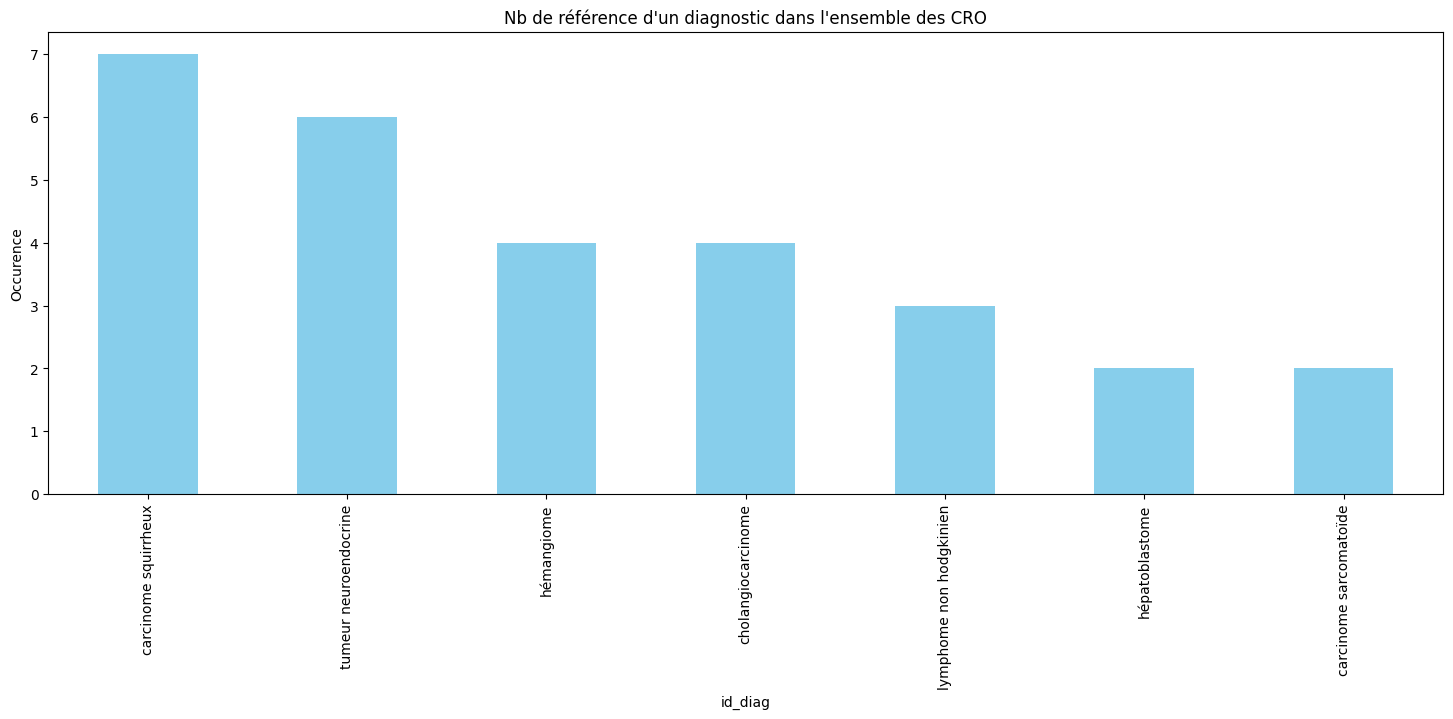

In [176]:
# affichage des diag augmentés

try:
    value_counts_bis_bis = new_CRO_test['diagnostic'].value_counts()

    plt.figure(figsize=(18, 6))
    value_counts_bis_bis.plot(kind='bar', color='skyblue')
    plt.title("Nb de référence d'un diagnostic dans l'ensemble des CRO")
    plt.xlabel('id_diag')
    plt.ylabel('Occurence')
except:
    new_CRO_test = new_CRO_test

In [177]:
#  ajout des nouveaux CRO aux anciens

CRO_test_fusion = pd.concat((CRO_test, new_CRO_test), ignore_index=True)
CRO_test_fusion.head(5)

,id_med,id_diag,nir,CRO,source,operation,address,birthday,organe,diagnostic,cancer,name_patient,name_med
0,47,22,2 1984 04 75625 231 34,Rapport d'examen histologique :\nPatiente : As...,mistralai/Mistral-7B-Instruct-v0.2,exérèse,"9, rue de Blin, 75625 Saint Michelboeuf",14/04/1984,foie,cystadénome,0,Astrid Bouchet,Dr Thierry Goncalves
1,92,28,1 1967 07 79813 483 48,Résumé anatomopathologique\nPatient : M. Berna...,mistralai/Mistral-7B-Instruct-v0.2,exérèse,"2, rue Océane Guilbert, 79813 Morin",23/07/1967,foie,hyperplasie nodulaire focale,0,Bernard Charles,Dr Hélène Boulanger
2,27,28,1 1945 11 76266 494 47,Résumé anatomo-pathologique pour Thibault Guib...,mistralai/Mistral-7B-Instruct-v0.2,exérèse,"avenue de Bonnet, 76266 Guyot",13/11/1945,foie,hyperplasie nodulaire focale,0,Thibaut Guibert,Dr Aimé Guichard
3,10,30,1 1950 01 28629 857 67,Résumé anatomopathologique\nPatient : Victor R...,mistralai/Mistral-7B-Instruct-v0.2,exérèse,"42, boulevard Seguin, 28629 Julien-sur-Grenier",02/01/1950,foie,lymphome non hodgkinien,1,Victor Robin,Dr Antoine Boulanger
4,83,29,1 2005 09 38359 956 76,Résumé anatomopathologique\nPatient : William ...,mistralai/Mistral-7B-Instruct-v0.2,exérèse,"rue de Courtois, 38359 Bonneau-sur-Voisin",08/09/2005,foie,carcinome à petites cellules,1,William Morel,Dr Véronique Lambert


In [178]:
print(len(new_CRO_test))
print(len(CRO_test))
print(len(new_CRO_test) + len(CRO_test))
print(len(CRO_test_fusion))

28
173
201
201


Text(0, 0.5, 'Occurence')

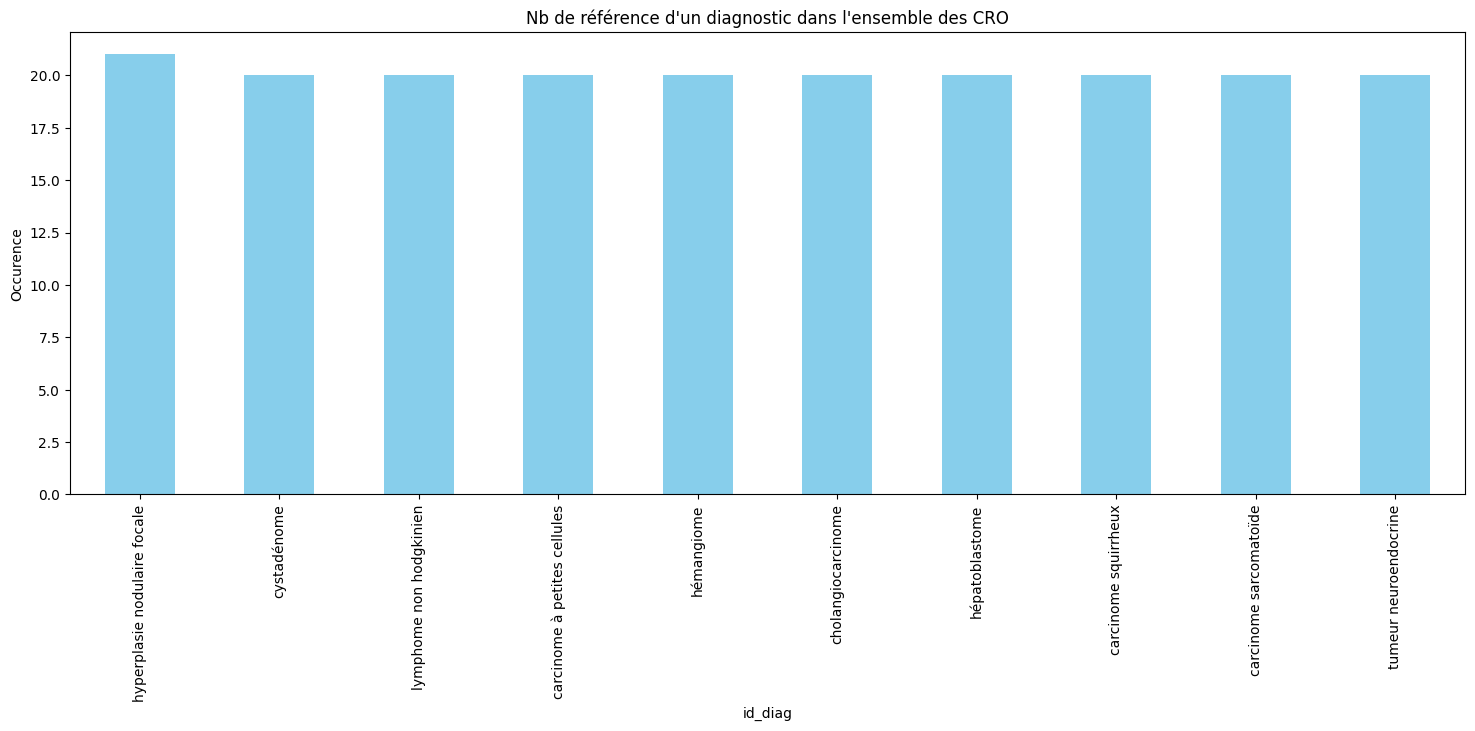

In [179]:
value_counts_bis_bis = CRO_test_fusion['diagnostic'].value_counts()

plt.figure(figsize=(18, 6))
value_counts_bis_bis.plot(kind='bar', color='skyblue')
plt.title("Nb de référence d'un diagnostic dans l'ensemble des CRO")
plt.xlabel('id_diag')
plt.ylabel('Occurence')

In [180]:
# Mise à niveau du dataframe pour correspondre à la limite sélectionnée par diag

nb_lignes_par_classe = ref

grouped_CRO_test = CRO_test_fusion.groupby('diagnostic', group_keys=False)
CRO_test_eq = grouped_CRO_test.apply(lambda x: x.sample(nb_lignes_par_classe, random_state=42))
CRO_test_eq = CRO_test_eq.reset_index(drop=True)

print('avant réduction:',len(CRO_test_fusion))
print('après réduction:',len(CRO_test_eq))

avant réduction: 201
après réduction: 200


In [181]:
print(CRO_test_eq['diagnostic'].value_counts())

diagnostic
carcinome sarcomatoïde          20
carcinome squirrheux            20
carcinome à petites cellules    20
cholangiocarcinome              20
cystadénome                     20
hyperplasie nodulaire focale    20
hémangiome                      20
hépatoblastome                  20
lymphome non hodgkinien         20
tumeur neuroendocrine           20
Name: count, dtype: int64


# Création du fichier JSON

In [182]:
def find_occurrences(texte: str, mot: str) -> list:
    ''' 
    trouve toutes les occurrences d'un mot/phrase en renvoyant les index de début
    - entrée : - texte (str) => texte dans lequel le mot doit être recherché
               - mot (str) => mot recherché dans le texte
    - sortie : list de tous les index de début de localisation dans le texte
    '''
    occurrences = []
    index = -1
    while True:
        texte = texte.lower()
        # trouve toutes les occurences d'un mot dans le texte jusqu'à la fin
        index = texte.find(mot.lower(), index + 1)
        if index == -1:
            break

        index_fin = index + len(mot)

        # vérifie par quoi se termine le mot pour éviter les mots dérivés du mot recherché
        if texte[index_fin] in [' ', ',', '.', ')', ':'] or texte[index] not in ['s']:
            occurrences.append(index)
        else:
            print("mot suivi d'une lettre", mot, '\n', texte[index:])

        if -1 in occurrences:
            raise
    return occurrences

def normalisation_texte(texte: str): 
    '''
    mise en minuscule et suppression des retours à la ligne \n.
    '''   
    texte_normalise = texte.replace('\n', ' ')

    return texte_normalise

In [183]:
def csv_to_json(df: pd.DataFrame, file_json : Path) -> str:
    '''
    Génération d'un fichier JSON qui rassemble le texte, les index de début et de fin de chaque mot associé à leur label
    - entrées : - df (pd.DataFrame): dataframe ressemblant le texte et l'ensemble des mots ou groupes de mots recherchés dans le texte.
                - file_json (str): adresse de lecture et de d'enregistrement du fichier JSON
    - sortie : un fichier JSON
    '''
    df_to_json = []

    for i in range(0, len(df)):
        # variables qui comptent le nb de fois qu'une valeur est trouvé dans le texte
        compteur_diag = 0
        # compteur_loc = 0
        # compteur_per = 0
        # compteur_med = 0
        # compteur_date = 0

        list_ner = []
        dict_ner = {'entities': []}
        # text = normalisation_texte(df.CRO[i])
        text = df.CRO[i]

        # ajout du texte au dictionnaire
        list_ner.append(text)

        # recherche les occurrences des diagnostics
        diag = df.diagnostic[i].lower()
        diag_index = find_occurrences(text, diag)

        for k in diag_index:
            end = k + len(diag) 
            compteur_diag += 1       
            dict_ner['entities'].append([k, end, 'DIAG'])
        
        # # recherche les occurrences des anatomopathologistes
        # med = df.name_med[i].lower()
        # med_index = find_occurrences(text, med.lower())

        # for k in med_index:
        #     end = k + len(med) 
        #     compteur_med += 1       
        #     dict_ner['entities'].append([k, end, 'DOC'])
        
        # # recherche les occurrences des patients
        # nom_patient = df.name_patient[i].lower()
        # name_index = find_occurrences(text, nom_patient.lower())

        # for k in name_index:
        #     end = k + len(nom_patient)  
        #     compteur_per += 1      
        #     dict_ner['entities'].append([k, end, 'PER'])       

        # # recherche les occurrences d'une adresse' (sous toutes leurs formes)
        # adresse = df.address[i].lower()
        # adresse_index = find_occurrences(text, adresse.lower())

        # for k in adresse_index:
        #     end = k + len(adresse) 
        #     compteur_loc += 1       
        #     dict_ner['entities'].append([k, end, 'LOC'])
        
        # # recherche les occurences des dates 
        # birthday = df.birthday[i].lower()
        # birthday_index = find_occurrences(text, birthday.lower())

        # for k in birthday_index:
        #     end = k + len(birthday)  
        #     compteur_date += 1      
        #     dict_ner['entities'].append([k, end, 'DATE'])
        
        # # chaque label doit apparaitre au moins une fois dans le texte
        # if compteur_date >= 1 and compteur_diag >= 1 and compteur_loc >= 1 and compteur_per >= 1 and compteur_med >=1:
        #     print("Les conditions sont satisfaites.")
        # else:
        #     print("Les conditions ne sont pas satisfaites. Il manque:")
        #     if compteur_date == 0:
        #         print(birthday)
        #     if compteur_diag == 0:
        #         print(diag)
        #     if compteur_loc == 0:
        #         print(adresse)
        #     if compteur_med == 0:
        #         print(med)
        #     if compteur_per == 0:
        #         print(nom_patient)
        #     print("Dans le CRO à l'index ", i, df.CRO[i])

        # ajout les différents index de début et de fin au dictionnaire
        dict_ner['entities'] = sorted(dict_ner['entities'], key=lambda x: x[2])
        list_ner.append(dict_ner)              
        df_to_json.append(list_ner)

    # ouverture du fichier JSON
    to_json = json.dumps(df_to_json, ensure_ascii=False)

    with open(file_json, 'w', encoding="utf-8") as fichier:
        # écriture du fichier JSON, ajout si existe déjà !
        fichier.write(to_json)
    return len(df_to_json)

In [184]:
train_data = CRO_train_eq.sample(n=len(CRO_train_eq), ignore_index=True, random_state=42)
valid_data = CRO_valid_eq.sample(n=len(CRO_valid_eq), ignore_index=True, random_state=42)
test_data = CRO_test_eq.sample(n=len(CRO_test_eq), ignore_index=True, random_state=42)


print('génération du fichier json train')
taille_json_train = csv_to_json(train_data, '../generate_model/assets/train.json')
print(f'La data train possède {len(train_data)}, le JSON train contient {taille_json_train} entrées.')

print('génération du fichier json valid')
taille_json_valid = csv_to_json(valid_data, '../generate_model/assets/dev.json')
print(f'La data valid possède {len(valid_data)}, le JSON valid contient {taille_json_valid} entrées.')

print('génération du fichier json test')
taille_json_test = csv_to_json(test_data, '../generate_model/assets/test.json')
print(f'La data test possède {len(test_data)}, le JSON test contient {taille_json_test} entrées.')

génération du fichier json train
La data train possède 2000, le JSON train contient 2000 entrées.
génération du fichier json valid
La data valid possède 500, le JSON valid contient 500 entrées.
génération du fichier json test
La data test possède 200, le JSON test contient 200 entrées.


In [185]:
def pourcentage_ressemblance(liste1, liste2):
    # Convertir les listes en ensembles pour éliminer les doublons
    ensemble1 = set(liste1)
    ensemble2 = set(liste2)

    # Calculer le nombre d'éléments communs
    elements_communs = len(ensemble1.intersection(ensemble2))

    # Calculer le pourcentage de ressemblance
    pourcentage_ressemblance = (elements_communs / len(ensemble1.union(ensemble2))) * 100

    return round(pourcentage_ressemblance, 2)

In [186]:
resultat = pourcentage_ressemblance(train_data.nir.unique().tolist(), valid_data.nir.unique().tolist())
print(f"Le pourcentage de patients à la fois dans le train et le valid est de:\n {resultat}%")


Le pourcentage de patients à la fois dans le train et le valid est de:
 100.0%


In [187]:
resultat = pourcentage_ressemblance(train_data.id_med.unique().tolist(), valid_data.id_med.unique().tolist())
print(f"Le pourcentage d'anatomopathologistes à la fois dans le train et le valid est de:\n {resultat}%")

Le pourcentage d'anatomopathologistes à la fois dans le train et le valid est de:
 100.0%
